In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as     plt
from   matplotlib.colors import LogNorm

import invisible_cities.core    .fit_functions   as     fitf
import invisible_cities.io      .pmap_io         as     pmpio
import invisible_cities.database.load_db         as     db
from   invisible_cities.reco    .dst_functions   import load_xy_corrections
from   invisible_cities.reco    .corrections     import LifetimeCorrection
from   invisible_cities.reco    .xy_algorithms   import barycenter
from   invisible_cities.reco    .xy_algorithms   import corona
from   invisible_cities.types   .ic_types        import xy

from   invisible_cities.icaro   .hst_functions   import hist
from   invisible_cities.icaro   .hst_functions   import hist2d
from   invisible_cities.icaro   .hst_functions   import resolution
from   invisible_cities.icaro   .hst_functions   import measurement_string
from   invisible_cities.icaro   .hst_functions   import poisson_sigma
from   invisible_cities.icaro   .hst_functions   import gausstext
from   invisible_cities.icaro   .hst_functions   import labels

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 15, 12
plt.rcParams["font.size"]      = 25

In [3]:
run_number    = 4587
filenames     = glob.glob("/Users/Gonzalo/github/NEXTdata/Cs137/{}/pmaps*.h5".format(run_number))
corr_pitch    = 5.4 # 4.0, 5.4, 8.1, 16.5
corrections   = "/Users/Gonzalo/github/ICARO/icaro/KrMay/run4446_corrections_{}mm.h5".format(corr_pitch)
XYcorrection  = load_xy_corrections(corrections)
LT, u_LT      = 1475, 50
LTcorrection  = LifetimeCorrection(LT, u_LT)
S12filter     = True
zfilter       = False
lfilter       = False
rfilter       = False
nmin, nmax    =    1, 4
zmin, zmax    =    0, 520
lmin, lmax    =    0, 100
rmin, rmax    =    0, 200
corona_opts   = {
    "Qthr"          :  2,
    "Qlm"           : 10,
    "lm_radius"     : 20,
    "new_lm_radius" : 25,
    "msipm"         :  6,
}

Total    # events = 128873
Selected # events = 121399


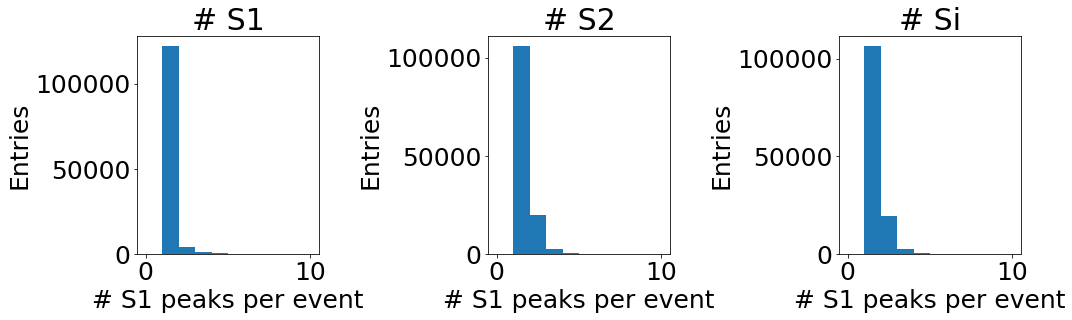

In [4]:
s1ds, s2ds, sids = zip(*map(pmpio.load_pmaps, filenames))

s1s_, s2s_, sis_ = {}, {}, {}
list(map(s1s_.update, s1ds))
list(map(s2s_.update, s2ds))
list(map(sis_.update, sids))

plt.figure(figsize=(15,5))
get_npeaks = lambda x: getattr(x, "number_of_peaks")
plt.subplot(1,3,1);plt.hist(list(map(get_npeaks, s1s_.values())), np.arange(11));labels("# S1 peaks per event", "Entries" , "# S1")
plt.subplot(1,3,2);plt.hist(list(map(get_npeaks, s2s_.values())), np.arange(11));labels("# S1 peaks per event", "Entries" , "# S2")
plt.subplot(1,3,3);plt.hist(list(map(get_npeaks, sis_.values())), np.arange(11));labels("# S1 peaks per event", "Entries" , "# Si")
plt.tight_layout()

evt_nos = set(s1s_.keys()) | set(s2s_.keys()) | set(sis_.keys())
print("Total    # events =", len(evt_nos))

# Get those events with exactly 1 S1 and 1 S2 (both in PMTs and SiPMs)
evt_nos = set(s1s_.keys()) & set(s2s_.keys()) & set(sis_.keys())

if S12filter:
    evt_nos = list(filter(lambda evt:         get_npeaks(s1s_[evt]) == 1 and \
                                      nmin <= get_npeaks(s2s_[evt]) == get_npeaks(sis_[evt]) <= nmax, evt_nos))
if zfilter:
    evt_nos = list(filter(lambda evt: zmin <= (s2s_[evt][0].t[0] -
                                               s1s_[evt][0].t[0])/1000 < zmax         , evt_nos))
if lfilter:
    evt_nos = list(filter(lambda evt: lmin <= len(s2s_[evt][0].t) < lmax              , evt_nos))

nevt = len(evt_nos)
print("Selected # events =", len(evt_nos))

s1s = {k:v for k,v in s1s_.items() if k in evt_nos}
s2s = {k:v for k,v in s2s_.items() if k in evt_nos}
sis = {k:v for k,v in sis_.items() if k in evt_nos}

datasipm = db.DataSiPM(run_number)

In [5]:
def sum_evt_ene(s2):
    return [peak.E.sum() for peak in s2.peaks.values()]

def rebin(arr, n_rebin, op=np.sum):
    n_bins  = int(np.ceil(arr.size/n_rebin))
    return np.array([op(arr[i*n_rebin:(i+1)*n_rebin]) for i in range(n_bins)])
    resized = np.resize(arr, (n_bins, n_rebin))
    return op(resized, axis=1)

def correct_evt_ene_(s1, s2, si, n_rebin=1):
    Ecorr = []
    s1_time = s1.peak_waveform(0).t[np.argmax(s1.peak_waveform(0).E)]
    for peak in s2.peak_collection():
        t, E    = (getattr(s2.peak_waveform(peak), att) for att in ("t", "E"))
        E_peak  = 0
        si_peak = si.s2sid[peak]
        nslices = int(np.ceil(t.size/n_rebin))

        within_ = True
        t = rebin(t, n_rebin, op=np.mean)
        E = rebin(E, n_rebin)
        Q = {sipm: rebin(q, n_rebin) for sipm, q in si_peak.items()}
        Q = [{sipm:(qs[i] if i < len(qs) else 0) for sipm, qs in Q.items()} for i in range(nslices)]
        for i in range(nslices):
            Z  = (t[i] - s1_time) / 1000
            e0 = E[i] * LTcorrection(Z).value
            e  = e0
            sipms, qsipm = list(map(list, zip(*Q[i].items())))
            if np.sum(qsipm) > 0:
                xsipm = datasipm.X.values[sipms]
                ysipm = datasipm.Y.values[sipms]

                possipm  = list(zip(xsipm, ysipm))
                clusters = barycenter(possipm, qsipm)
                #clusters = corona(np.array(possipm), np.array(qsipm), **corona_opts)

                e    = 0
                qsum = sum(cluster.Q for cluster in clusters)
                for cluster in clusters:
                    if rfilter and (cluster.X**2 + cluster.Y**2)**0.5 > rmax:
                        within_ = False
                        break
                    e   += e0 * cluster.Q / qsum * XYcorrection(cluster.X, cluster.Y).value[0]
            E_peak += e
        Ecorr.append(E_peak)
    return Ecorr

def correct_evt_ene(n_rebin=1):
    return lambda *args, **kwargs: correct_evt_ene_(*args, n_rebin=n_rebin, **kwargs)

def get(var, array):
    return np.array(list(map(lambda x: getattr(x, var), array)))

def npmap(*args, **kwargs):
    return np.array(list(map(*args, **kwargs)))

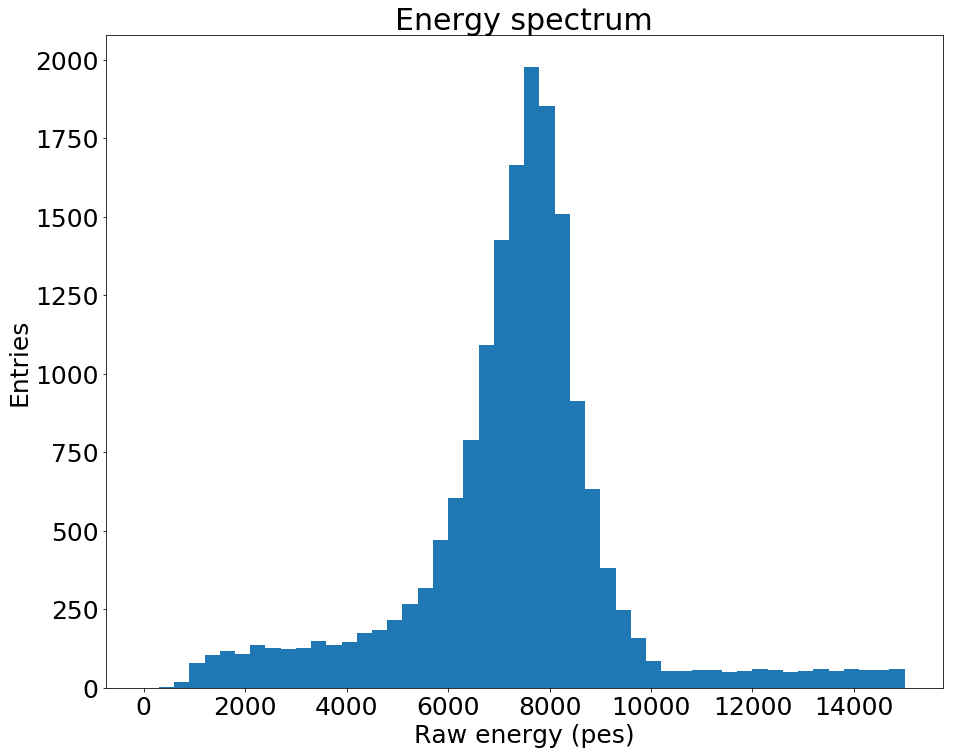

In [6]:
E_raw = []
list(map(E_raw.extend, map(sum_evt_ene, s2s.values())))
hist(E_raw, 50, (0, 15e3))
labels("Raw energy (pes)", "Entries", "Energy spectrum")

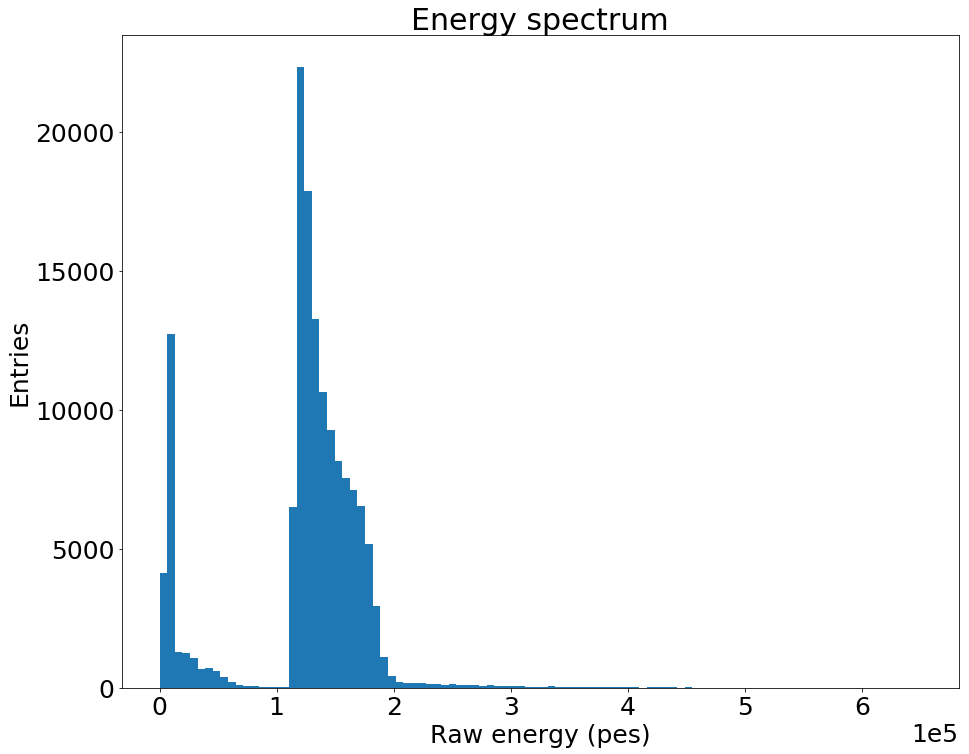

In [7]:
E_raw = []
list(map(E_raw.extend, map(sum_evt_ene, s2s.values())))
hist(E_raw, 100, (0, 650e3))

plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
labels("Raw energy (pes)", "Entries", "Energy spectrum")
plt.savefig("22Na_raw_spectrum.pdf")

In [8]:
Ecorr    = []
rebin_to = 2
list(map(Ecorr.extend, map(correct_evt_ene(rebin_to), s1s.values(), s2s.values(), sis.values())))
Ecorr = np.array(Ecorr)

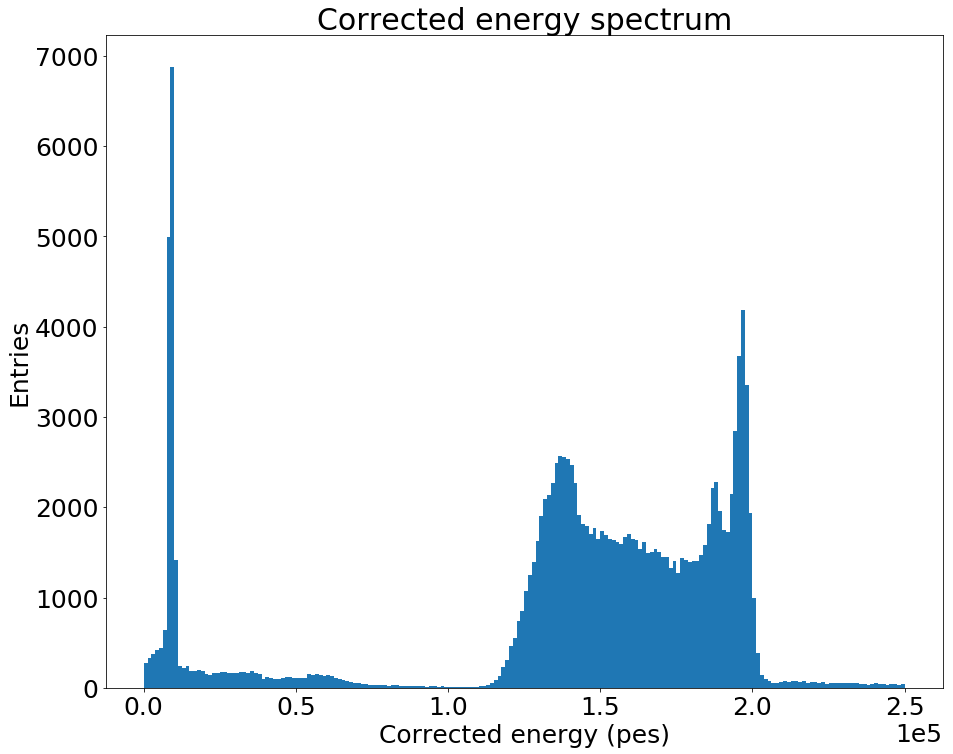

In [9]:
hist(Ecorr, 200, (0e3, 250e3))
plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
labels("Corrected energy (pes)", "Entries", "Corrected energy spectrum")
plt.savefig("22Na_corrected_spectrum_{}mm_rebin{}.pdf".format(corr_pitch, rebin_to))

Resolution at 29.7 keV: 8.10 +- 0.14
Resolution at 2458 keV: 0.890 +- 0.016
Chi2                  : 3.07088409559


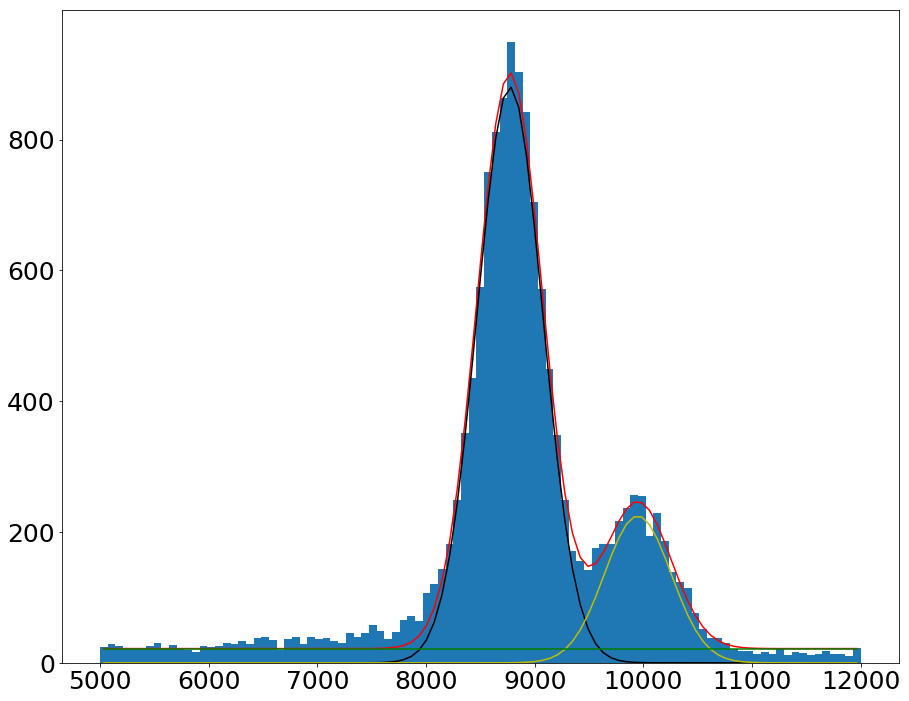

In [10]:
bins     = np.linspace(5e3, 12e3, 100)
bin_size = np.diff(bins)[0] 
y, x, _  = hist(Ecorr, bins)
fun      = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + args[6]
seed     = Ecorr.size * bin_size, 10e3, 1e2, 1e6, 11500, 1e2, 2

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e5, 9000, 100, 1e5, 10000, 100, 2
fitr = 8e3, 11e3

f = fitf.fit(fun, x, y, seed, fit_range=fitr, sigma=poisson_sigma(y))

assert not np.any(np.isclose(f.values, seed))

print("Resolution at 29.7 keV:", measurement_string(*resolution(f.values, f.errors, 29.7)[0]))
print("Resolution at 2458 keV:", measurement_string(*resolution(f.values, f.errors, 29.7)[1]))
print("Chi2                  :", f.chi2)

plt.plot(x, f.fn(x), "r-")
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")


Resolution at 662  keV: 2.528 +- 0.042
Resolution at 662  keV: 2.050 +- 0.100
Resolution at 2458 keV: 1.312 +- 0.022
Chi2                  : 1.85934634146


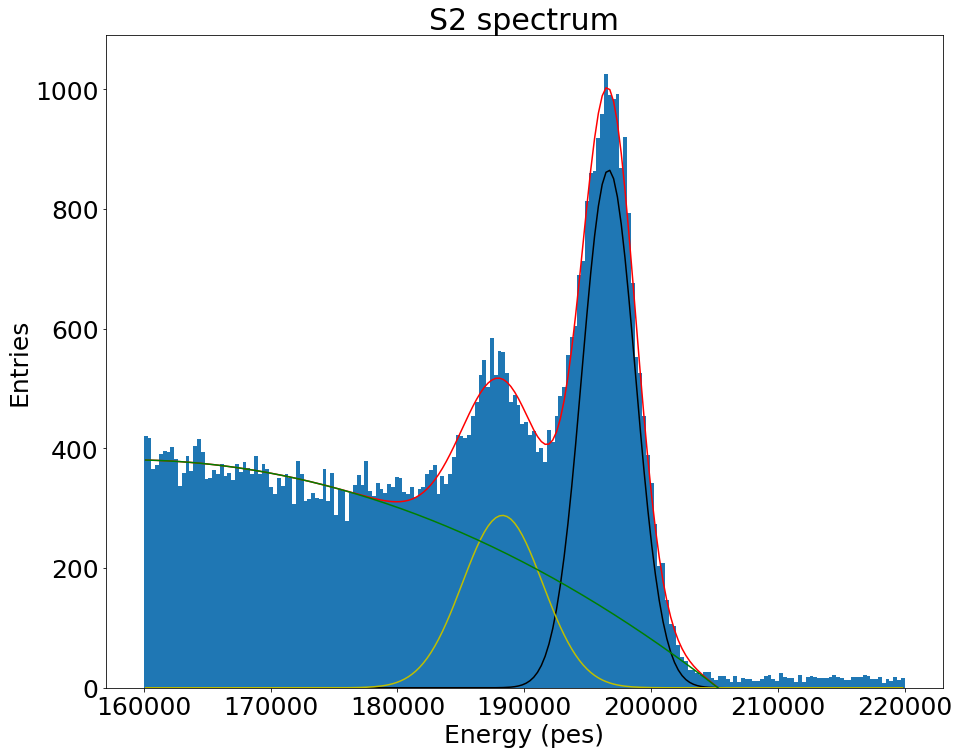

In [18]:
y, x, _ = \
hist(Ecorr, 200, (160e3, 220e3))

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e5, 200e3, 1e3, 1e5, 190e3, 1e3, 1e2, 40, -1e-4
fitr = 160e3, 205e3

f = fitf.fit(fun, x, y, seed, fit_range=fitr, sigma=poisson_sigma(y))

assert not np.any(np.isclose(f.values, seed))

print("Resolution at 662  keV:", measurement_string(*resolution(f.values, f.errors, 662)[0]))
print("Resolution at 662  keV:", measurement_string(*resolution(f.values[3:], f.errors[3:], 662)[1]))
print("Resolution at 2458 keV:", measurement_string(*resolution(f.values, f.errors, 662)[1]))
print("Chi2                  :", f.chi2)

plt.plot(x, f.fn(x), "r-")
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")

plt.ylim(0)
labels("Energy (pes)", "Entries", "S2 spectrum")